Random use of kmeans and agglomerative clustering

In [80]:
rand_dist = np.random.rand(8000,2)

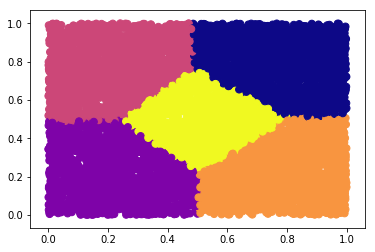

In [81]:
test_km = cluster.KMeans(n_clusters=5, n_init=100)
test_km.fit(rand_dist)
# Classify
predire = test_km.predict(rand_dist)
# Labels
couleurs = np.unique(predire)
# Evaluation of the silhouette score
silou = metrics.silhouette_score(rand_dist, predire)
#create a scatter plot
plt.scatter(rand_dist[:, 0], rand_dist[:, 1], c=predire, s=50, cmap='plasma');

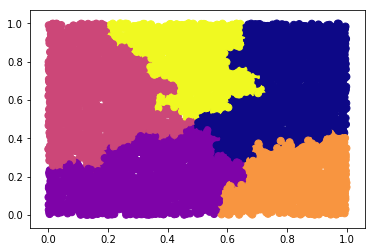

In [82]:
test_hc = cluster.AgglomerativeClustering(n_clusters=5)
predire = test_hc.fit_predict(rand_dist)
# Labels
couleurs = np.unique(predire)
# Evaluation of the silhouette score
silou = metrics.silhouette_score(rand_dist, predire)
#create a scatter plot
plt.scatter(rand_dist[:, 0], rand_dist[:, 1], c=predire, s=50, cmap='plasma');

# 1) Importations

In [1]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing, decomposition, metrics, linear_model, model_selection, cluster, svm

Populating the interactive namespace from numpy and matplotlib


# 2) Data

In [2]:
# Getting current path
path = os.getcwd()
try :
    customers_df = pd.read_csv(path + "/data/customers_data.csv")
    print("Loading customers dataset")
    display(customers_df.head())
    customers_rfm = pd.read_csv(path + "/data/customers_rfm.csv")
    print("Loading customers RFM dataset")
    display(customers_rfm.head())
    customers_bulk = pd.read_csv(path + "/data/customer_bulk.csv", index_col='CustomerID_enc')
    print("Loading customers bulk dataset")
    display(customers_bulk.head())
except FileNotFoundError:
    print("ERROR : check if the files are in the 'data' folder")

Loading customers dataset


,ID_enc,ID,1st_order,1st_order_qty,1st_order_descr,1st_order_amount,mf_order,mf_order_qty,mf_order_descr,mf_order_amount
0,0,12346.0,23166,74215,MEDIUM CERAMIC TOP STORAGE JAR,77183.60,23166,12,MEDIUM CERAMIC TOP STORAGE JAR,15.00
1,1,12747.0,85124C,12,GREEN JUICY FRUIT PHOTO FRAME,30.60,82484,2,WOOD BLACK BOARD ANT WHITE FINISH,15.90
2,2,12748.0,22854,1,CREAM SWEETHEART EGG HOLDER,4.95,21034,1,REX CASH+CARRY JUMBO SHOPPER,0.95
3,3,12749.0,22768,2,FAMILY PHOTO FRAME CORNICE,19.90,22720,3,SET OF 3 CAKE TINS PANTRY DESIGN,14.85
4,4,12820.0,21977,24,PACK OF 60 PINK PAISLEY CAKE CASES,13.20,22086,6,PAPER CHAIN KIT 50'S CHRISTMAS,17.70


Loading customers RFM dataset


,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,325,1,77183.60,4,4,1,441
1,2,103,4196.01,1,1,1,111
2,0,4397,31650.78,1,1,1,111
3,3,198,4040.88,1,1,1,111
4,3,59,942.34,1,2,2,122


Loading customers bulk dataset


,Amount,Bulk
CustomerID_enc,,
1,40.737961,3.524379
2,7.198267,3.167508
3,20.408485,2.778461
4,15.971864,6.182251
5,15.453333,5.758253


Selecting relevant features for each dataframe

In [3]:
customers_df = customers_df.drop(['ID_enc', 'ID', '1st_order_descr', 'mf_order_descr'], axis=1)
display(customers_df.head())
customers_rfm = customers_rfm.loc[:, ['recency', 'frequency', 'monetary_value']]
display(customers_rfm.head())

,1st_order,1st_order_qty,1st_order_amount,mf_order,mf_order_qty,mf_order_amount
0,23166,74215,77183.60,23166,12,15.00
1,85124C,12,30.60,82484,2,15.90
2,22854,1,4.95,21034,1,0.95
3,22768,2,19.90,22720,3,14.85
4,21977,24,13.20,22086,6,17.70


,recency,frequency,monetary_value
0,325,1,77183.60
1,2,103,4196.01
2,0,4397,31650.78
3,3,198,4040.88
4,3,59,942.34


Label encoding product codes in order to use the feature in our models

In [4]:
unique_products = pd.concat((customers_df.loc[:, '1st_order'], customers_df.loc[:, 'mf_order'])).unique()
le_codes = preprocessing.LabelEncoder()
le_codes = le_codes.fit(unique_products)
customers_df['1st_order_enc'] = le_codes.transform(customers_df['1st_order'])
customers_df['mf_order_enc'] = le_codes.transform(customers_df['mf_order'])
customers_df = customers_df.drop(['1st_order', 'mf_order'], axis=1)

# 3) Standardisation

## 3.1) Customers dataframe

Standard scaling the dataframe

In [5]:
std_scaler_cust_df = preprocessing.StandardScaler().fit(customers_df)
customers_df_std = std_scaler_cust_df.transform(customers_df)
customers_df_std = pd.DataFrame(customers_df_std, columns=customers_df.columns)
customers_df_mat_std = customers_df_std.values

In [6]:
customers_df_std.corr()

,1st_order_qty,1st_order_amount,mf_order_qty,mf_order_amount,1st_order_enc,mf_order_enc
1st_order_qty,1.000000,0.995416,-0.000416,-0.000572,0.011386,0.004577
1st_order_amount,0.995416,1.000000,-0.000664,-0.000696,0.016016,0.008453
mf_order_qty,-0.000416,-0.000664,1.000000,0.999972,0.007248,0.016398
mf_order_amount,-0.000572,-0.000696,0.999972,1.000000,0.007399,0.016888
1st_order_enc,0.011386,0.016016,0.007248,0.007399,1.000000,0.131736
mf_order_enc,0.004577,0.008453,0.016398,0.016888,0.131736,1.000000


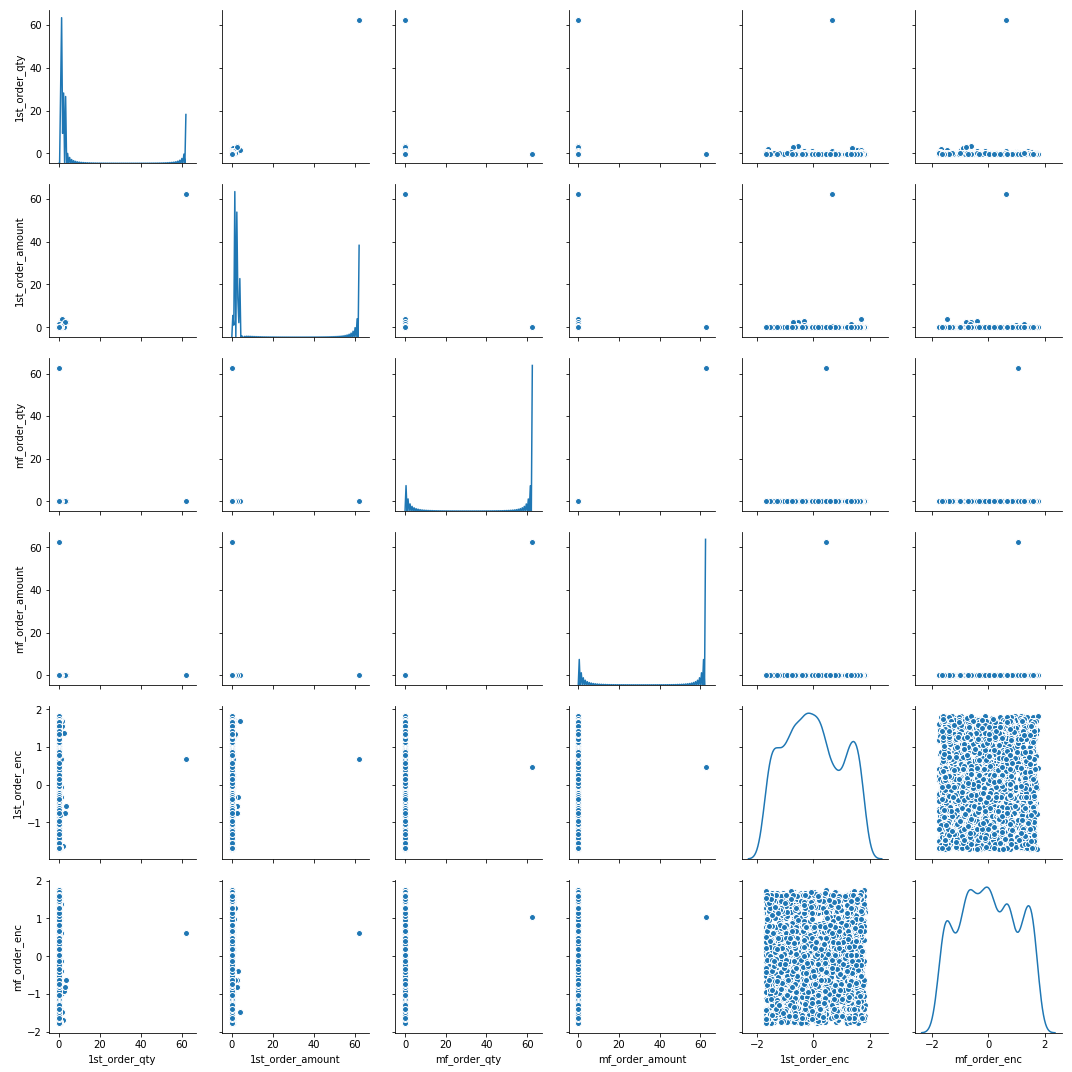

In [7]:
sns.pairplot(customers_df_std, diag_kind='kde');

One obvious thing to observe from this pairplor is the presence of an outlier. Most likely the 1st entry that we can observe displaying a first order with a very high quantity and total amount. This may lead to poor classification results as this point in particular might be considered as it's own class.

On another hand we can see how close the datapoints are to one another. This may lead to clustering difficulties as well.

## 3.2) RFM dataframe

Standard scaling the dataframe

In [8]:
std_scaler_cust_df = preprocessing.StandardScaler().fit(customers_rfm)
customers_rfm_std = std_scaler_cust_df.transform(customers_rfm)
customers_rfm_std = pd.DataFrame(customers_rfm_std, columns=customers_rfm.columns)
customers_rfm_mat_std = customers_rfm_std.values

In [9]:
customers_rfm_std.corr()

,recency,frequency,monetary_value
recency,1.000000,-0.212809,-0.129084
frequency,-0.212809,1.000000,0.321026
monetary_value,-0.129084,0.321026,1.000000


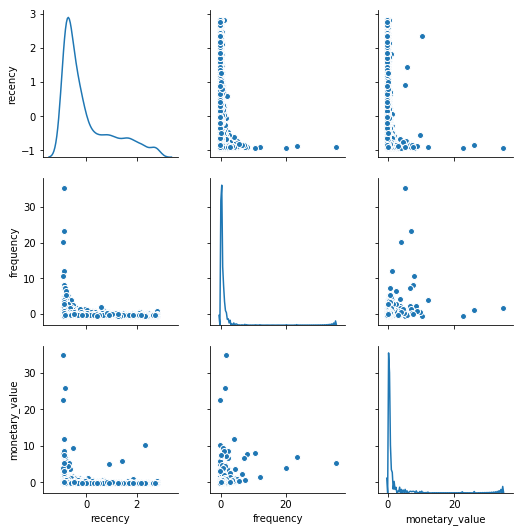

In [10]:
sns.pairplot(customers_rfm_std, diag_kind='kde');

Similarly, those RFM datapoints are quite close to one another.

## 3.3) Bulk dataframe

Standard scaling the dataframe

In [11]:
std_scaler_cust_df = preprocessing.StandardScaler().fit(customers_bulk)
customers_bulk_std = std_scaler_cust_df.transform(customers_bulk)
customers_bulk_std_df = pd.DataFrame(customers_bulk_std, columns=customers_bulk.columns)

In [12]:
customers_bulk_std_df.corr()

,Amount,Bulk
Amount,1.000000,0.612073
Bulk,0.612073,1.000000


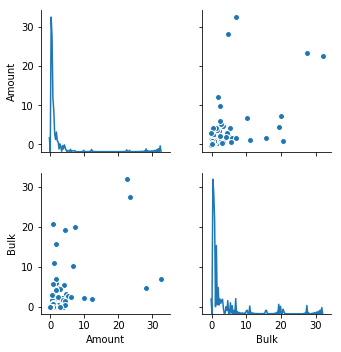

In [13]:
sns.pairplot(customers_bulk_std_df, diag_kind='kde');

The dispersion is reduced as our points are close to one another

# 4) Dimensionality reduction

Let's see if a PCA dimension reduction is of interest here with the few features we have

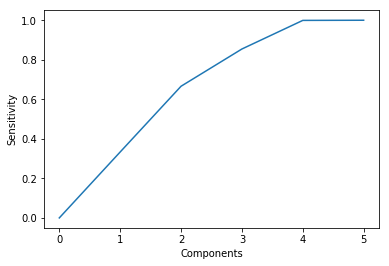

In [14]:
expvar = []
for i in range(customers_df.shape[1]) :
    pca = decomposition.PCA(n_components=i)
    pca.fit(customers_df_std)
    expvar.append(pca.explained_variance_ratio_.sum())

plt.plot(np.arange(0, customers_df.shape[1]), expvar)
ax = plt.gca()
ax.set_xlabel('Components')
ax.set_ylabel('Sensitivity');

There is no obvious "elbow" on the curve therefore we won't use PCA dimensionality reduction

# 5) Clustering

## 5.1) On customers dataframe

### 5.1.1) KMeans

In [15]:
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(customers_df_mat_std)
    # Classify
    preds = classif.predict(customers_df_mat_std)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(customers_df_mat_std, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.98 for 2 clusters
Average silhouette score : 0.98 for 3 clusters
Average silhouette score : 0.35 for 4 clusters
Average silhouette score : 0.37 for 5 clusters
Average silhouette score : 0.38 for 6 clusters
Average silhouette score : 0.38 for 7 clusters
Average silhouette score : 0.38 for 8 clusters
Average silhouette score : 0.38 for 9 clusters
Average silhouette score : 0.37 for 10 clusters
Average silhouette score : 0.37 for 11 clusters
Best silhouette score : 0.979 for 3 clusters


silhouette score : 0.979 for 3 clusters


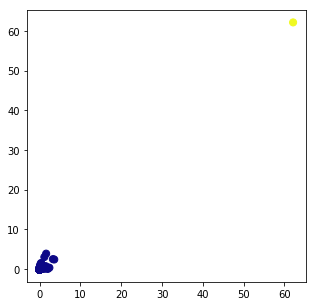

In [16]:
kmeans = cluster.KMeans(n_clusters=best_n, n_init=100)
kmeans.fit(customers_df_std)
clusters_customers = kmeans.predict(customers_df_mat_std)
silhouette_avg = metrics.silhouette_score(customers_df_mat_std, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, best_n))

fig, ax = plt.subplots(figsize=(5,5))
#create a scatter plot
plt.scatter(customers_df_mat_std[:, 0], customers_df_mat_std[:, 1], c=clusters_customers, s=50, cmap='plasma');

In [17]:
unique, counts = numpy.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 3914, 1: 1, 2: 1}

This poor clustering is realy interesting as it displays well the dependence of the algorithm to outliers. Let's see if we can improve the outcome by getting rid of this outlier at the top right corner : an order with a high quantity and high amount, ringing any bell ?

In [18]:
lines_to_remove = list(set(np.where(customers_df_mat_std > 50)[0].tolist()))

In [19]:
customers_df_mat_std_red = np.delete(customers_df_mat_std, lines_to_remove, axis=0)

New pairplot

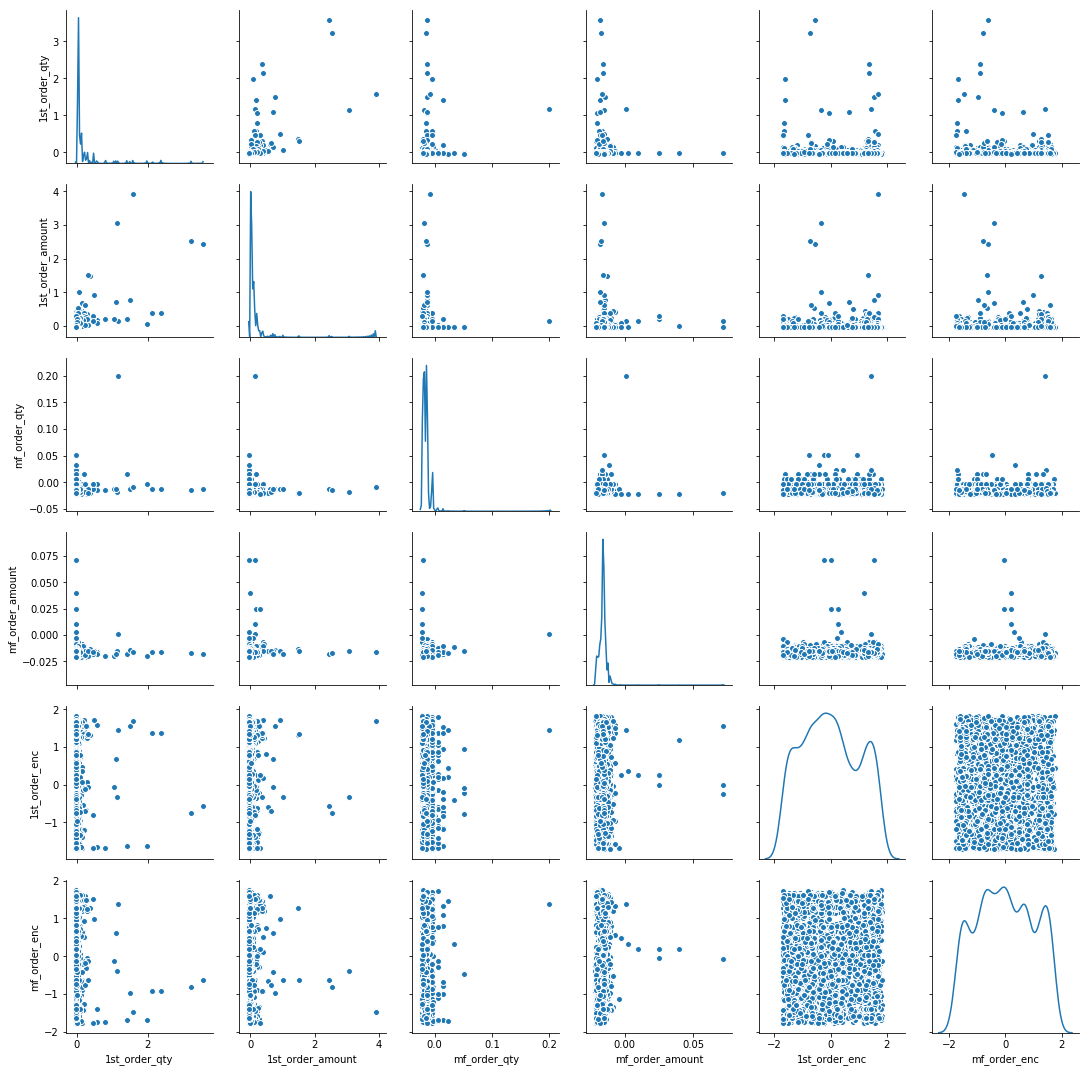

In [20]:
sns.pairplot(pd.DataFrame(customers_df_mat_std_red, columns=customers_df.columns), diag_kind='kde');

This is a bit better but not quite perfect, we do not expect much better results

In [21]:
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(customers_df_mat_std_red)
    # Classify
    preds = classif.predict(customers_df_mat_std_red)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(customers_df_mat_std_red, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.35 for 2 clusters
Average silhouette score : 0.37 for 3 clusters
Average silhouette score : 0.38 for 4 clusters
Average silhouette score : 0.38 for 5 clusters
Average silhouette score : 0.38 for 6 clusters
Average silhouette score : 0.38 for 7 clusters
Average silhouette score : 0.37 for 8 clusters
Average silhouette score : 0.37 for 9 clusters
Average silhouette score : 0.38 for 10 clusters
Average silhouette score : 0.38 for 11 clusters
Best silhouette score : 0.383 for 5 clusters


silhouette score : 0.383 for 5 clusters


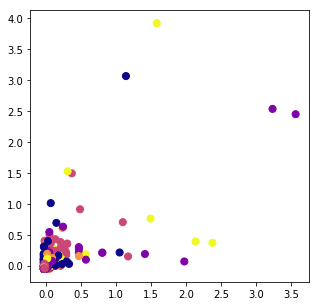

In [22]:
kmeans = cluster.KMeans(n_clusters=best_n, n_init=100)
kmeans.fit(customers_df_mat_std_red)
clusters_customers = kmeans.predict(customers_df_mat_std_red)
silhouette_avg = metrics.silhouette_score(customers_df_mat_std_red, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, best_n))

fig, ax = plt.subplots(figsize=(5,5))
#create a scatter plot
plt.scatter(customers_df_mat_std_red[:, 0], customers_df_mat_std_red[:, 1], c=clusters_customers, s=50, cmap='plasma');

The clustering is still quite poor but at least we know have a better view over our datapoints. But still not quite satisfying as the majority of our datapoints are bulked in one group. 

Let's try passing our datapoints to a logaritmic scale rather than standardising them.

In [23]:
customers_df_temp = customers_df.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
customers_df_log = customers_df_temp.apply(np.log)

New pairplot

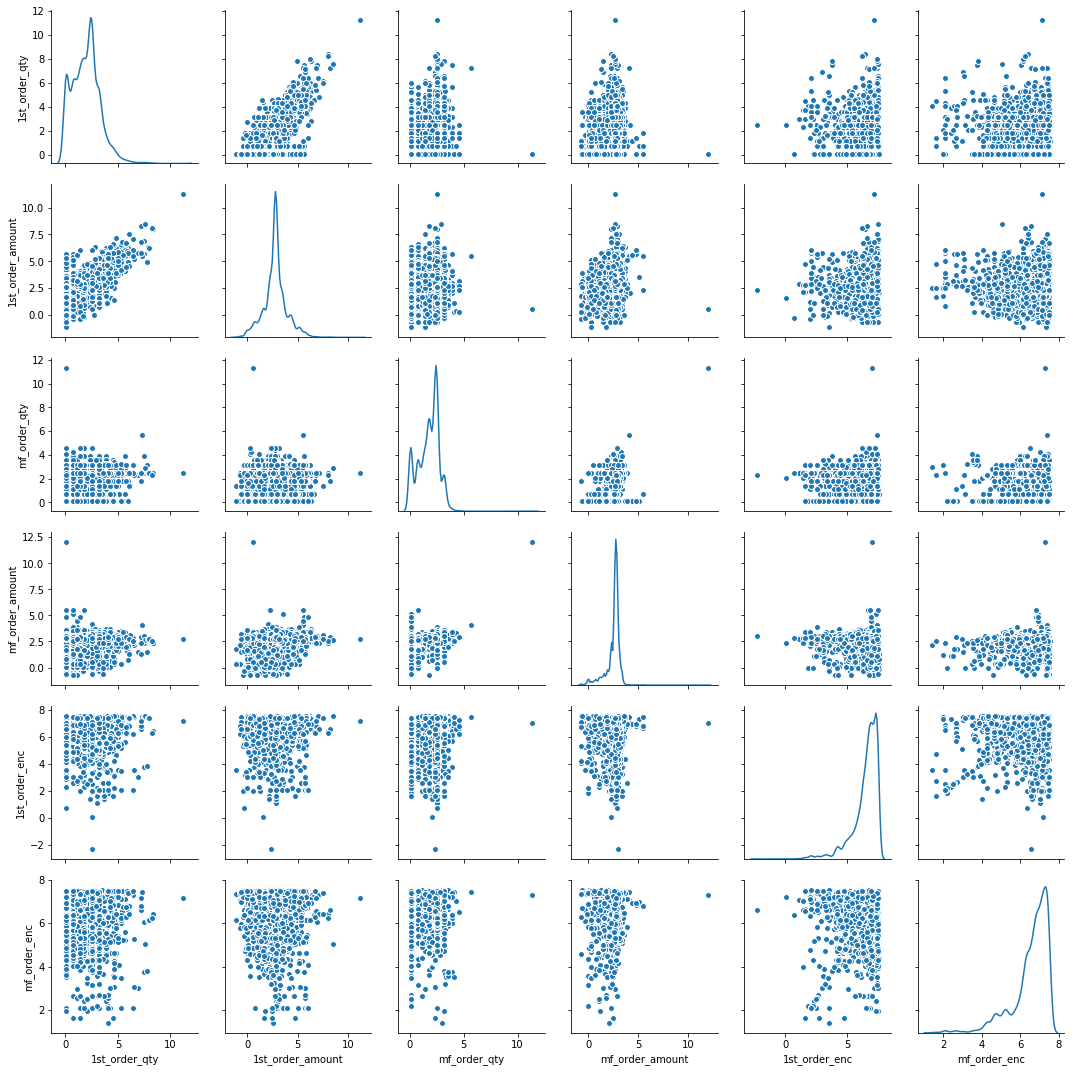

In [24]:
sns.pairplot(customers_df_log, diag_kind='kde');

This is nicer as our data are much better separated, clustering seems more doable this time

In [25]:
data = customers_df_log.values
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.20 for 2 clusters
Average silhouette score : 0.20 for 3 clusters
Average silhouette score : 0.22 for 4 clusters
Average silhouette score : 0.21 for 5 clusters
Average silhouette score : 0.21 for 6 clusters
Average silhouette score : 0.19 for 7 clusters
Average silhouette score : 0.20 for 8 clusters
Average silhouette score : 0.19 for 9 clusters
Average silhouette score : 0.17 for 10 clusters
Average silhouette score : 0.18 for 11 clusters
Best silhouette score : 0.215 for 4 clusters


Apparently this clustering is not formidable, let us have a look at clustering with 2 to 7 clusters

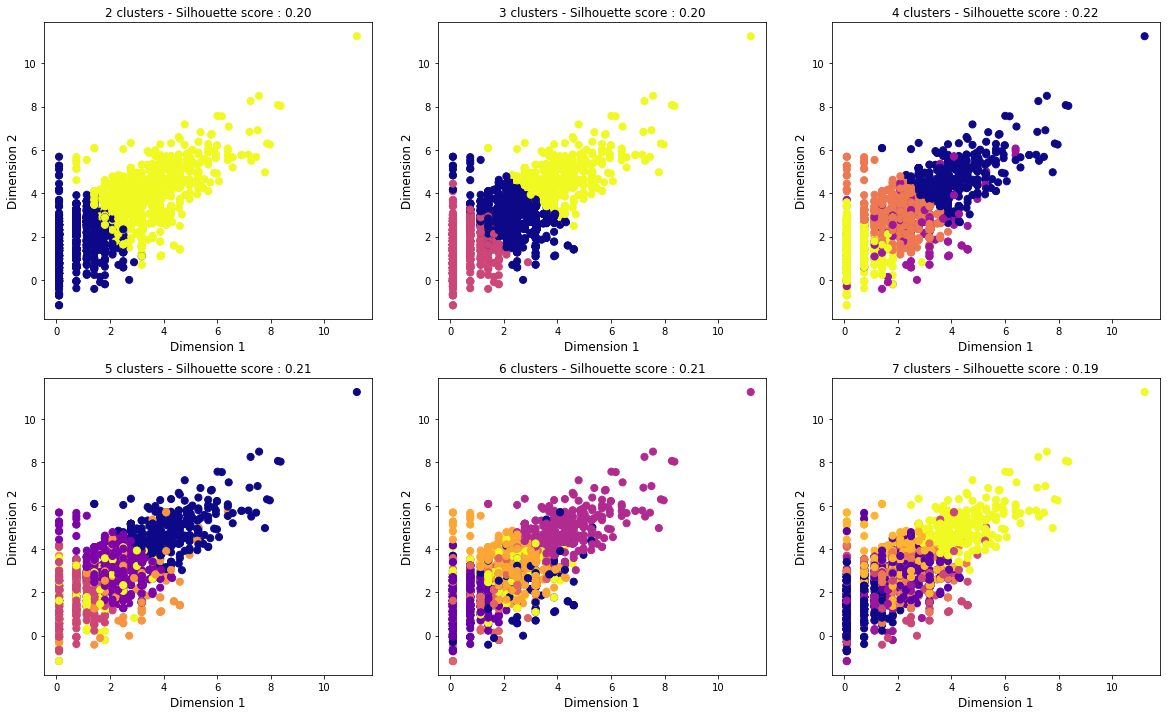

In [26]:
fig = plt.figure(figsize=(20,12))
data = customers_df_log.values

for n_clust, dim in zip(range(2,8), range(1,7)) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Labels
    labels = np.unique(preds)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    #create a scatter plot
    ax = fig.add_subplot(2, 3, dim)
    ax.scatter(data[:, 0], data[:, 1], c=preds, s=50, cmap='plasma')
    ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)
    ax.set_title('{:d} clusters - Silhouette score : {:.2f}'.format(n_clust, silhouette), fontsize=12);

The 2-clusters classification seems easy enough to detailed :

silhouette score : 0.199 for 2 clusters


,1,0
NumberCustomers,2109,1807


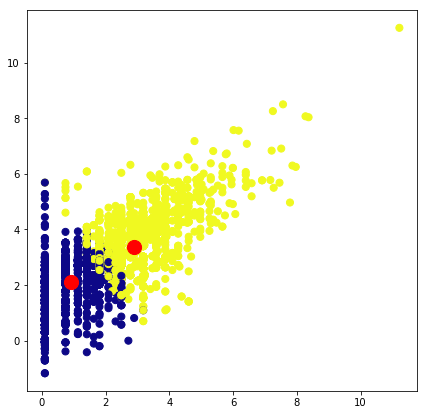

In [27]:
nclust = 2
kmeans = cluster.KMeans(n_clusters=nclust, n_init=100)
kmeans.fit(data)
clusters_customers = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, nclust))

fig, ax = plt.subplots(figsize=(7,7))
#create a scatter plot
ax.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');

#select cluster centers
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200)

# Number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

As these are plots showing the 1st order amount as a function of the 1ser order quantity, this is a clustomer "1st order behaviour" segmentation :

- Lower-Left corner : Customers ordering small quantities for small total amount
- Middle : Customers ordering average quantities for average total amount
- Upper-Right corner : Customers ordering high quantities for high total amount

### 5.1.2) Agglomerative clustering

In [28]:
data = customers_df_log.values
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.AgglomerativeClustering(n_clusters=n_clust)
    # Classify
    preds = classif.fit_predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette

Average silhouette score : 0.22 for 2 clusters
Average silhouette score : 0.16 for 3 clusters
Average silhouette score : 0.18 for 4 clusters
Average silhouette score : 0.19 for 5 clusters
Average silhouette score : 0.12 for 6 clusters
Average silhouette score : 0.13 for 7 clusters
Average silhouette score : 0.12 for 8 clusters
Average silhouette score : 0.13 for 9 clusters
Average silhouette score : 0.13 for 10 clusters
Average silhouette score : 0.12 for 11 clusters


score de silhouette: 0.219 for 2 clusters


,0,1
NumberCustomers,3363,553


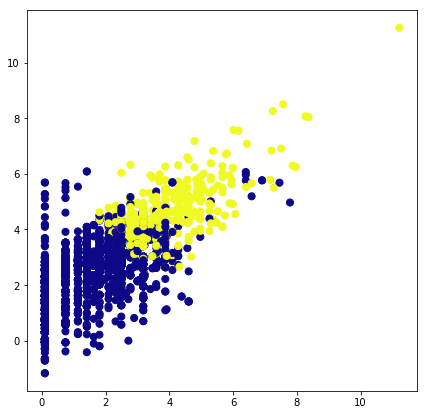

In [29]:
nclust=2
aggloclust = cluster.AgglomerativeClustering(n_clusters=nclust)
clusters_customers = aggloclust.fit_predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('score de silhouette: {:<.3f} for {} clusters'.format(silhouette_avg, nclust))

fig, ax = plt.subplots(figsize=(7,7))
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');

# Number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

In order to try another algorithm we tried AgglomerativeClustering, with less delimited clusters. KMeans shows cleaner clusters.

## 5.2) On RFM dataframe

### 5.2.1) KMeans

In [30]:
data = customers_rfm_mat_std
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.57 for 2 clusters
Average silhouette score : 0.59 for 3 clusters
Average silhouette score : 0.59 for 4 clusters
Average silhouette score : 0.62 for 5 clusters
Average silhouette score : 0.59 for 6 clusters
Average silhouette score : 0.52 for 7 clusters
Average silhouette score : 0.52 for 8 clusters
Average silhouette score : 0.47 for 9 clusters
Average silhouette score : 0.42 for 10 clusters
Average silhouette score : 0.42 for 11 clusters
Best silhouette score : 0.617 for 5 clusters


silhouette score : 0.617 for 5 clusters


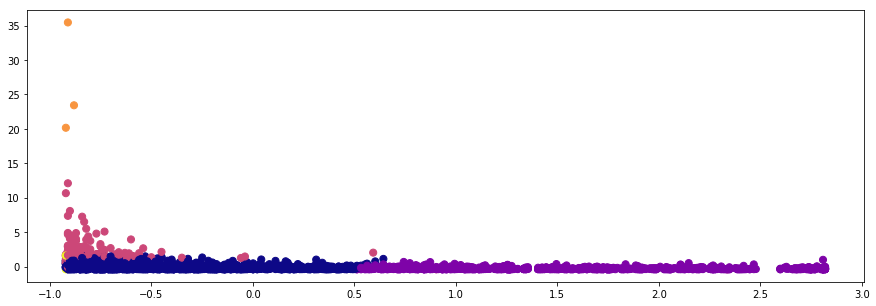

In [31]:
kmeans = cluster.KMeans(n_clusters=best_n, n_init=100)
kmeans.fit(data)
clusters_customers = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, best_n))

fig, ax = plt.subplots(figsize=(15,5))
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');
#select cluster centers
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [32]:
unique, counts = numpy.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 2775, 1: 966, 2: 169, 3: 3, 4: 3}

This is an interesting clustering but, again, it lacks of readability. Let's scale our data to the log once more instead of standardising.

In [33]:
customers_rfm_temp = customers_rfm.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
customers_rfm_log = customers_rfm_temp.apply(np.log)

New pairplot

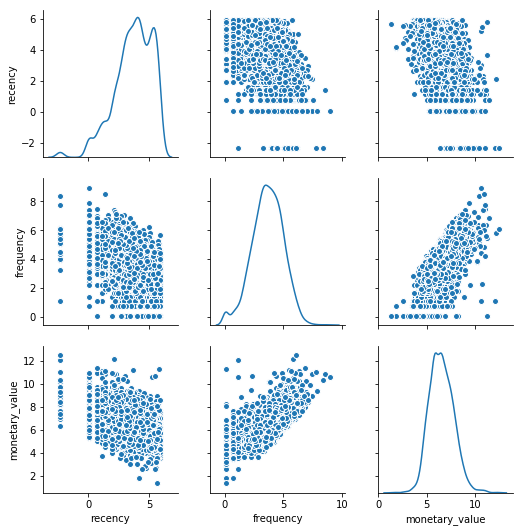

In [34]:
sns.pairplot(customers_rfm_log, diag_kind='kde');

This is nicer as our data are much better separated, clustering seems more doable this time

In [35]:
data = customers_rfm_log.values
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.40 for 2 clusters
Average silhouette score : 0.31 for 3 clusters
Average silhouette score : 0.31 for 4 clusters
Average silhouette score : 0.28 for 5 clusters
Average silhouette score : 0.26 for 6 clusters
Average silhouette score : 0.27 for 7 clusters
Average silhouette score : 0.27 for 8 clusters
Average silhouette score : 0.26 for 9 clusters
Average silhouette score : 0.26 for 10 clusters
Average silhouette score : 0.26 for 11 clusters
Best silhouette score : 0.395 for 2 clusters


Apparently this clustering is not formidable, let us have a look at clustering with 2 to 7 clusters

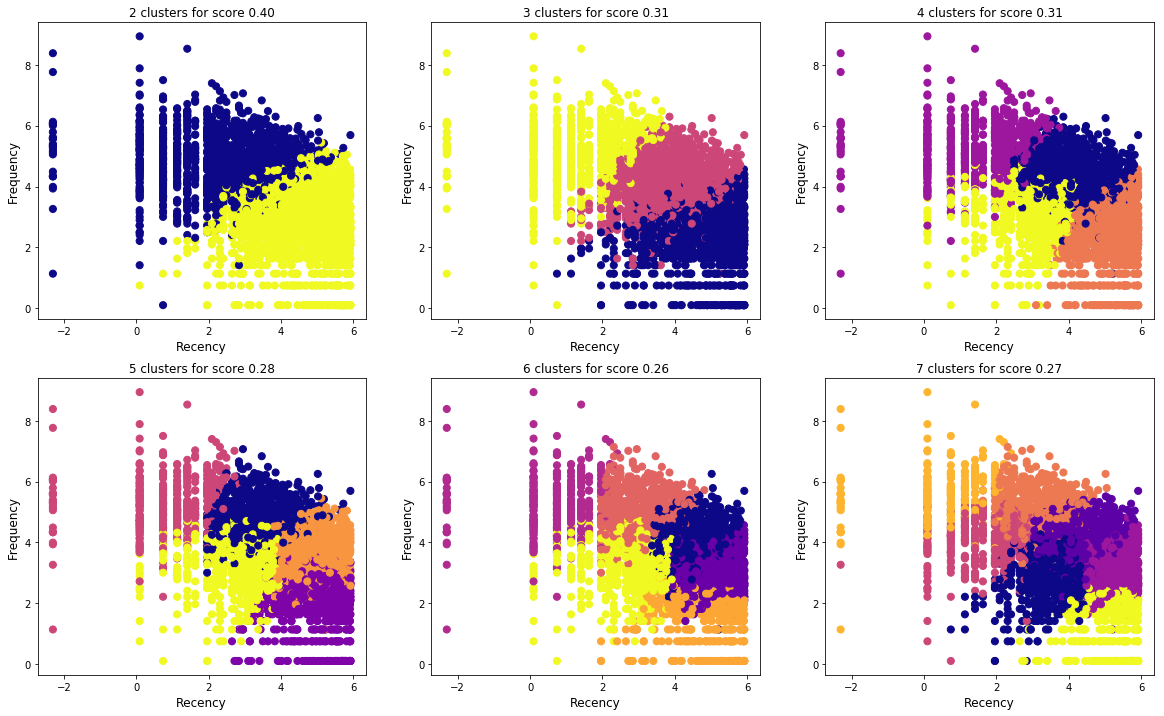

In [36]:
fig = plt.figure(figsize=(20,12))
data = customers_rfm_log.values

for n_clust, dim in zip(range(2,8), range(1,7)) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Labels
    labels = np.unique(preds)
    # Score
    silhouette = metrics.silhouette_score(data, preds)
    #create a scatter plot
    ax = fig.add_subplot(2, 3, dim)
    ax.scatter(data[:, 0], data[:, 1], c=preds, s=50, cmap='plasma')
    ax.set_xlabel('Recency', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('{:d} clusters for score {:.2f}'.format(n_clust, silhouette), fontsize=12);

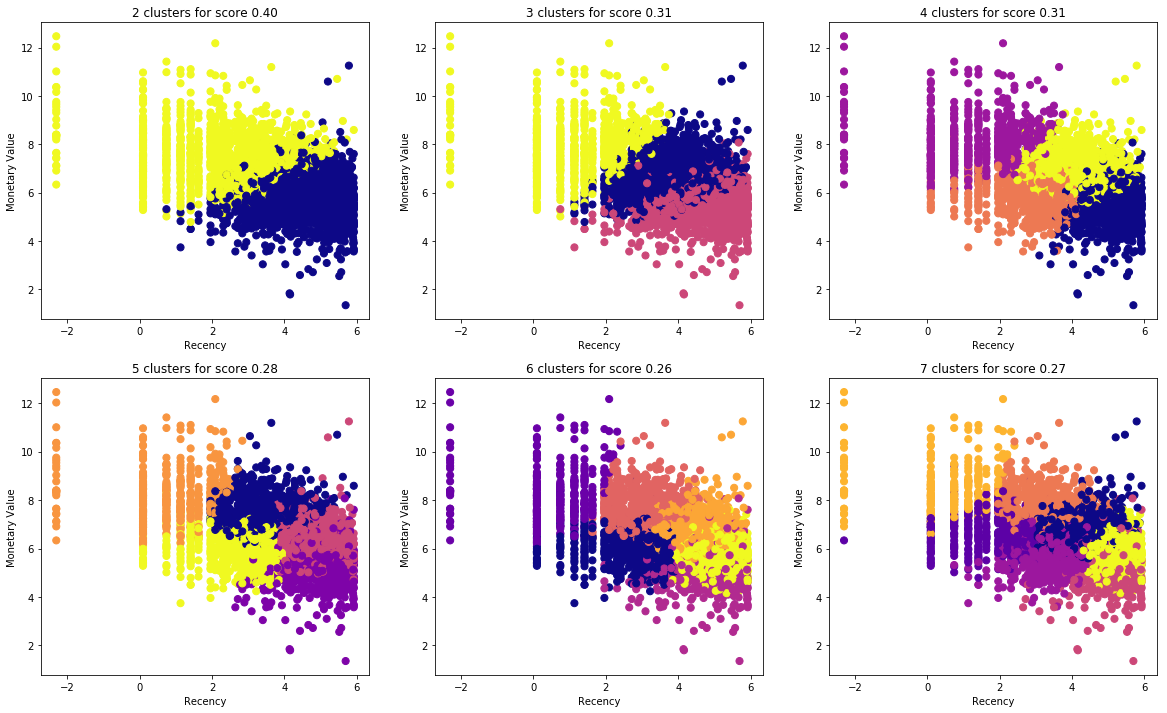

In [37]:
fig = plt.figure(figsize=(20,12))
data = customers_rfm_log.values

for n_clust, dim in zip(range(2,8), range(1,7)) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Labels
    labels = np.unique(preds)
    # Score
    silhouette = metrics.silhouette_score(data, preds)
    #create a scatter plot
    ax = fig.add_subplot(2, 3, dim)
    ax.scatter(data[:, 0], data[:, 2], c=preds, s=50, cmap='plasma')
    ax.set_xlabel('Recency')
    ax.set_ylabel('Monetary Value')
    ax.set_title('{:d} clusters for score {:.2f}'.format(n_clust, silhouette));

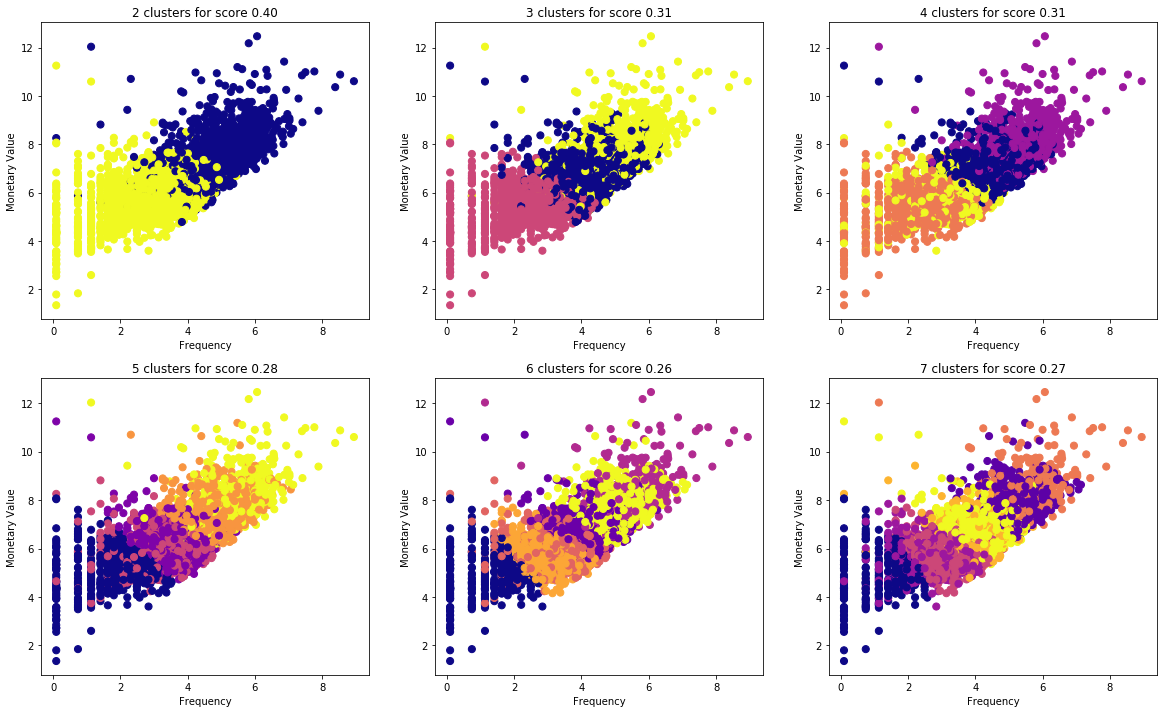

In [38]:
fig = plt.figure(figsize=(20,12))
data = customers_rfm_log.values

for n_clust, dim in zip(range(2,8), range(1,7)) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Labels
    labels = np.unique(preds)
    # Score
    silhouette = metrics.silhouette_score(data, preds)
    #create a scatter plot
    ax = fig.add_subplot(2, 3, dim)
    ax.scatter(data[:, 1], data[:, 2], c=preds, s=50, cmap='plasma')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Monetary Value')
    ax.set_title('{:d} clusters for score {:.2f}'.format(n_clust, silhouette));

Those are really encouraging results as we can see in each case clusters showing up. The silhouette score is not so high because our clusters are not very far from each others, they are even stuck to one another and mixed together on the borders. But we can identify areas quite clearly.

silhouette score : 0.308 for 4 clusters


,1,0,2,3
NumberCustomers,1243,1228,764,681


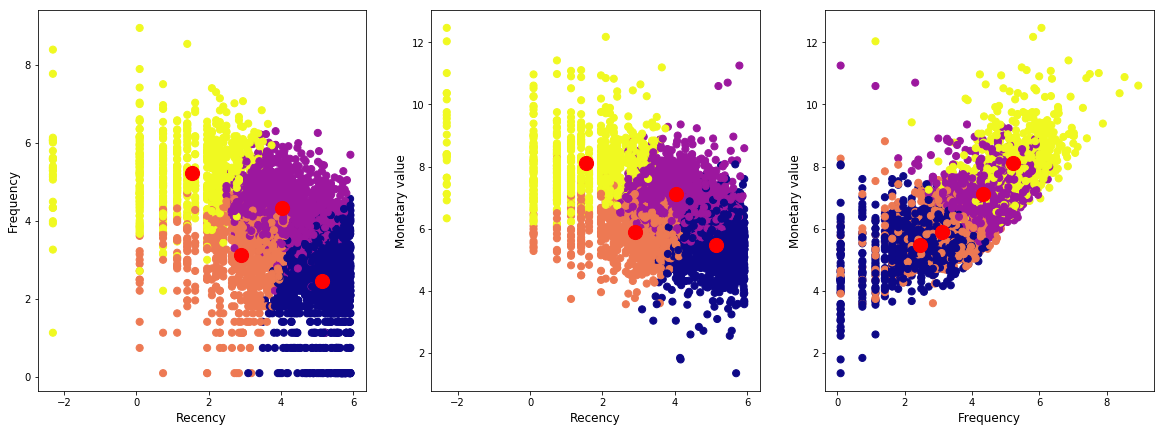

In [39]:
nclust = 4
kmeans = cluster.KMeans(n_clusters=nclust, n_init=100)
kmeans.fit(data)
clusters_customers = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, nclust))

# Number of customers in each cluster?
display(pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
#create a scatter plot
ax1.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
ax1.set_xlabel('Recency', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

#create a scatter plot
ax2.scatter(data[:, 0], data[:, 2], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 2], c='red', s=200)
ax2.set_xlabel('Recency', fontsize=12)
ax2.set_ylabel('Monetary value', fontsize=12)

#create a scatter plot
ax3.scatter(data[:, 1], data[:, 2], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
ax3.scatter(centers[:, 1], centers[:, 2], c='red', s=200)
ax3.set_xlabel('Frequency', fontsize=12)
ax3.set_ylabel('Monetary value', fontsize=12);

Here we can see how our data are separated regarding the features we are considering. It's harder to cluster from *Frequency/Monetary-Value* than from *Recency/Monetary-Value*

- **First Plot : Frequency = f (Recency) :**
    - *Lower-right cluster :* Almost lost to lost customers who ordered on scarce occasions -> not worth trying to get back
    - *Lower-center cluster :* Almost lost customers who ordered occasionally -> might be worth encouraging those
    - *Upper-center cluster :* Almost lost customers who ordered a lot -> customers we want to get back
    - *Upper-Left cluster :* Current customers who order often -> customers we want to keep
- **Second Plot : Monetary-Value = f (Recency) :**
    - *Lower-right cluster :* Almost lost to lost customers who ordered for small amounts -> not worth trying to get back
    - *Lower-center cluster :* Almost lost customers who ordered for average amounts -> might be worth encouraging those
    - *Upper-center cluster :* Almost lost customers who ordered for acceptable amounts -> customers we want to get back
    - *Upper-Left cluster :* Current customers who order for quite a bit of money -> customers we want to keep
- **Third Plot : Frequency = f (Monetary-Value) :**
The clusters are not separated enough

Does our RFM clustering works on our 1st order data ?

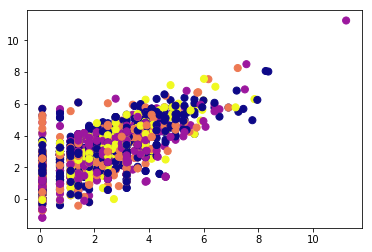

In [40]:
data = customers_df_log.values
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');

It does not

### 5.2.2) Agglomerative clustering

In [41]:
data = customers_rfm_log.values
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.AgglomerativeClustering(n_clusters=n_clust)
    # Classify
    preds = classif.fit_predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette

Average silhouette score : 0.35 for 2 clusters
Average silhouette score : 0.29 for 3 clusters
Average silhouette score : 0.20 for 4 clusters
Average silhouette score : 0.21 for 5 clusters
Average silhouette score : 0.19 for 6 clusters
Average silhouette score : 0.18 for 7 clusters
Average silhouette score : 0.19 for 8 clusters
Average silhouette score : 0.20 for 9 clusters
Average silhouette score : 0.19 for 10 clusters
Average silhouette score : 0.20 for 11 clusters


score de silhouette: 0.202 for 4 clusters


,0,1,3,2
NumberCustomers,1433,1336,808,339


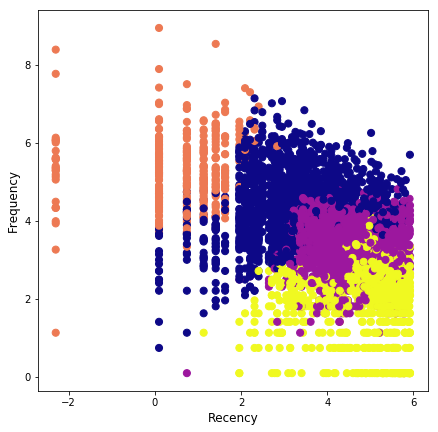

In [42]:
nclust=4
aggloclust = cluster.AgglomerativeClustering(n_clusters=nclust)
clusters_customers = aggloclust.fit_predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('score de silhouette: {:<.3f} for {} clusters'.format(silhouette_avg, nclust))

fig, ax = plt.subplots(figsize=(7,7))
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma')
ax.set_xlabel('Recency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

# Number of customers in each cluster?
display(pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T)

In order to try another algorithm we tried AgglomerativeClustering, with less delimited clusters. KMeans shows cleaner clusters.

## 5.3) On bulk dataframe

### 5.3.1) KMeans

In [43]:
silhouettes = []
best_silhouette = -2
best_n = 0
data = customers_bulk_std
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.99 for 2 clusters
Average silhouette score : 0.98 for 3 clusters
Average silhouette score : 0.93 for 4 clusters
Average silhouette score : 0.93 for 5 clusters
Average silhouette score : 0.90 for 6 clusters
Average silhouette score : 0.88 for 7 clusters
Average silhouette score : 0.85 for 8 clusters
Average silhouette score : 0.85 for 9 clusters
Average silhouette score : 0.76 for 10 clusters
Average silhouette score : 0.78 for 11 clusters
Best silhouette score : 0.986 for 2 clusters


silhouette score : 0.986 for 2 clusters


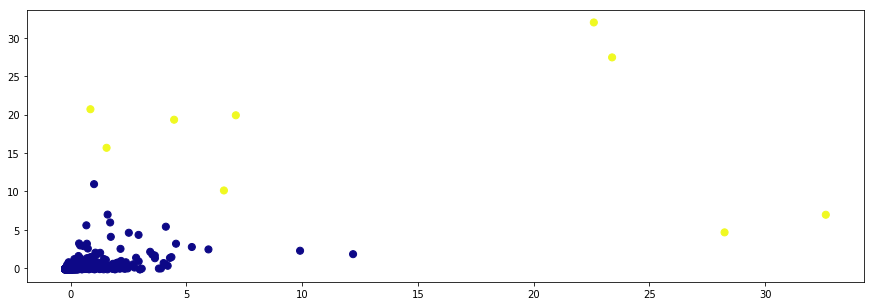

In [44]:
kmeans = cluster.KMeans(n_clusters=best_n, n_init=100)
kmeans.fit(data)
clusters_customers = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, best_n))

fig, ax = plt.subplots(figsize=(15,5))
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');

In [45]:
unique, counts = numpy.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 3904, 1: 9}

This poor clustering is realy interesting as it displays well the dependence of the algorithm to outliers.

This is a bit better but not quite perfect, we do not expect much better results

In [46]:
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(customers_df_mat_std_red)
    # Classify
    preds = classif.predict(customers_df_mat_std_red)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(customers_df_mat_std_red, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.35 for 2 clusters
Average silhouette score : 0.37 for 3 clusters
Average silhouette score : 0.38 for 4 clusters
Average silhouette score : 0.38 for 5 clusters
Average silhouette score : 0.38 for 6 clusters
Average silhouette score : 0.38 for 7 clusters
Average silhouette score : 0.37 for 8 clusters
Average silhouette score : 0.37 for 9 clusters
Average silhouette score : 0.38 for 10 clusters
Average silhouette score : 0.38 for 11 clusters
Best silhouette score : 0.383 for 5 clusters


silhouette score : 0.383 for 5 clusters


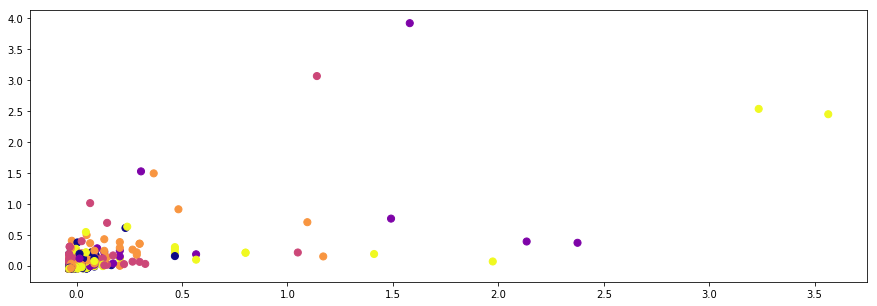

In [47]:
kmeans = cluster.KMeans(n_clusters=best_n, n_init=100)
kmeans.fit(customers_df_mat_std_red)
clusters_customers = kmeans.predict(customers_df_mat_std_red)
silhouette_avg = metrics.silhouette_score(customers_df_mat_std_red, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, best_n))

fig, ax = plt.subplots(figsize=(15,5))
#create a scatter plot
plt.scatter(customers_df_mat_std_red[:, 0], customers_df_mat_std_red[:, 1], c=clusters_customers, s=50, cmap='plasma');

The clustering is still quite poor but at least we know have a better view over our datapoints. But still not quite satisfying as the majority of our datapoints are bulked in one group. 

Let's try passing our datapoints to a logaritmic scale rather than standardising them.

In [48]:
customers_df_temp = customers_bulk.apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
customers_bulk_log = customers_df_temp.apply(np.log)

New pairplot

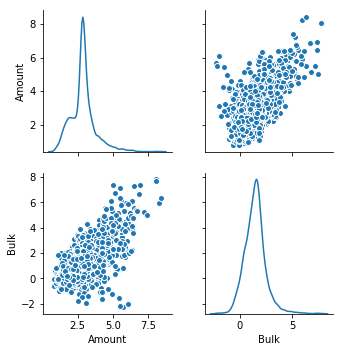

In [49]:
sns.pairplot(customers_bulk_log, diag_kind='kde');

This is nicer as our data are much better separated, clustering seems more doable this time

In [50]:
data = customers_bulk_log.values
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette
print('Best silhouette score : {:<.3f} for {} clusters'.format(best_silhouette, best_n))

Average silhouette score : 0.37 for 2 clusters
Average silhouette score : 0.47 for 3 clusters
Average silhouette score : 0.37 for 4 clusters
Average silhouette score : 0.37 for 5 clusters
Average silhouette score : 0.36 for 6 clusters
Average silhouette score : 0.35 for 7 clusters
Average silhouette score : 0.34 for 8 clusters
Average silhouette score : 0.35 for 9 clusters
Average silhouette score : 0.34 for 10 clusters
Average silhouette score : 0.34 for 11 clusters
Best silhouette score : 0.469 for 3 clusters


Apparently this clustering is not so bad !! Let us have a look at clustering with 2 to 7 clusters

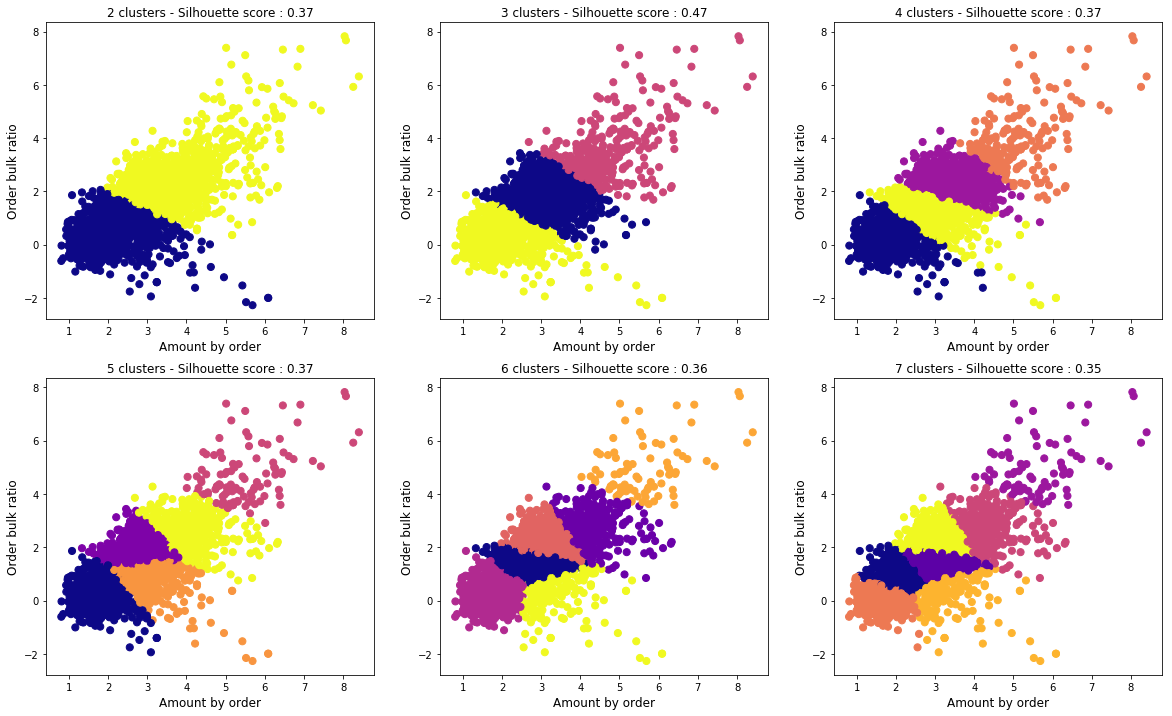

In [51]:
fig = plt.figure(figsize=(20,12))
data = customers_bulk_log.values

for n_clust, dim in zip(range(2,8), range(1,7)) :
    classif = cluster.KMeans(n_clusters=n_clust, n_init=100)
    # Fit classifier
    classif.fit(data)
    # Classify
    preds = classif.predict(data)
    # Labels
    labels = np.unique(preds)
    #create a scatter plot
    ax = fig.add_subplot(2, 3, dim)
    ax.scatter(data[:, 0], data[:, 1], c=preds, s=50, cmap='plasma')
    ax.set_xlabel("Amount by order", fontsize=12)
    ax.set_ylabel("Order bulk ratio", fontsize=12)
    silhouette = metrics.silhouette_score(data, preds)
    ax.set_title('{:d} clusters - Silhouette score : {:.2f}'.format(n_clust, silhouette), fontsize=12);

The 5-clusters classification seems easy enough to detailed :

silhouette score : 0.365 for 5 clusters


,0,1,2,3,4
NumberCustomers,850,1503,104,999,457


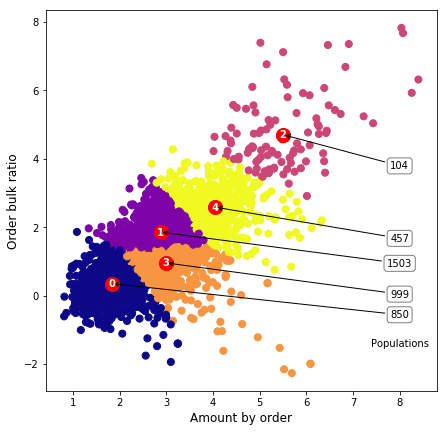

In [52]:
nclust = 5
kmeans = cluster.KMeans(n_clusters=nclust, n_init=100)
kmeans.fit(data)
clusters_customers_bulk = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers_bulk)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, nclust))

fig, ax = plt.subplots(figsize=(7,7))
#create a scatter plot
ax.scatter(data[:, 0], data[:, 1], c=clusters_customers_bulk, s=50, cmap='plasma')

#select cluster centers
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
ax.set_xlabel("Amount by order", fontsize=12)
ax.set_ylabel("Order bulk ratio", fontsize=12)

# Number of customers in each cluster?
clustering_population = pd.DataFrame(pd.Series(clusters_customers_bulk).value_counts().sort_index(), columns = ['NumberCustomers']).T
display(clustering_population)
# Add cluster population
for i in range(clustering_population.shape[1]) :
    # Annotation arrows for clusters population
    ax.annotate(str(clustering_population.iloc[0, i]), xy=(centers[i, 0], centers[i, 1]),  xycoords='data',
                bbox=dict(boxstyle="round", fc="none", ec="gray"),
                xytext=(8, centers[i, 1] - 1), ha='center',
                arrowprops=dict(arrowstyle="->"))
    # Number of cluster
    ax.text(centers[i, 0], centers[i, 1], str(clustering_population.columns.values[i]), weight='bold',
            fontsize=10, color='white', horizontalalignment='center', verticalalignment='center')
ax.text(8, -1.5, "Populations", fontsize=10, horizontalalignment='center');

We have our clustering : 5 clusters allow for at least 100 customers by cluster which we evaluate as acceptable

- **Label 3** : Customers buying in bulk for a high final price
    - **WHOLESALERS**
- **Label 1** : Customers with a tendency to buy in bulk for average amounts
    - **WHOLESALERS**
- **Label 4** : Customers with a tendency to buy in bulk for small to average amounts
    - **WHOLESALERS OR COMPANIES**
- **Label 0** : Customers with a tendency to buy on a retail basis for average to significant amounts
    - **COMPANIES**
- **Label 2** : Customers buying on a retail basis for small amounts
    - **PRIVATE BUYERS**

### 5.3.2) Agglomerative clustering

In [53]:
data = customers_bulk_log.values
silhouettes = []
best_silhouette = -2
best_n = 0
for n_clust in range(2,12) :
    classif = cluster.AgglomerativeClustering(n_clusters=n_clust)
    # Classify
    preds = classif.fit_predict(data)
    # Evaluation of the silhouette score
    silhouette = metrics.silhouette_score(data, preds)
    silhouettes.append(silhouette)
    print("Average silhouette score : %.2f for %i clusters" % (silhouette, n_clust))
    if silhouette > best_silhouette :
        best_n = n_clust
        best_silhouette = silhouette

Average silhouette score : 0.42 for 2 clusters
Average silhouette score : 0.45 for 3 clusters
Average silhouette score : 0.32 for 4 clusters
Average silhouette score : 0.33 for 5 clusters
Average silhouette score : 0.34 for 6 clusters
Average silhouette score : 0.33 for 7 clusters
Average silhouette score : 0.28 for 8 clusters
Average silhouette score : 0.30 for 9 clusters
Average silhouette score : 0.30 for 10 clusters
Average silhouette score : 0.30 for 11 clusters


score de silhouette: 0.332 for 5 clusters


,2,0,1,4,3
NumberCustomers,1489,1137,915,282,90


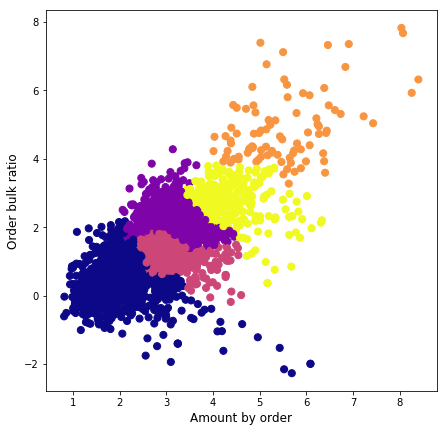

In [54]:
nclust=5
aggloclust = cluster.AgglomerativeClustering(n_clusters=nclust)
clusters_customers = aggloclust.fit_predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('score de silhouette: {:<.3f} for {} clusters'.format(silhouette_avg, nclust))

fig, ax = plt.subplots(figsize=(7,7))
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma')

ax.set_xlabel("Amount by order", fontsize=12)
ax.set_ylabel("Order bulk ratio", fontsize=12)

# Number of customers in each cluster?
display(pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T)

In order to try another algorithm we tried AgglomerativeClustering, with less delimited clusters. KMeans shows cleaner clusters.

# 5.4) Conclusions on clustering

### We have tried clustering 3 dataframes :
- **1) First order specifications**
    - This clustering gave interesting results especially after going log-scale but we can't attribuate a customer behaviour to this clustering features which are 1st order quantity and amount. We did that with the bulk dataframe.
- **2) RFM dataframe**
    - The RFM dataframe induces acceptable clustering but we cannot use RFM analysis on a single order, which is our purpose, therefore RFM analysis is not suitable for our case study.
- **3) Bulk tendendy dataframe**
    - The best clustering we came up with, suitable for customers segmentation as well as it displays a buying behaviour (retail or bulk and cheap or pricy).

As mentionned earlier, in order to be able to classify any customer from the very first order, we need to focus on he(she)'s first order specifications. Therefore we will focus on the **_Bulk tendency dataframe features_**.

We therefore will perform a clustering on these data, prior to run a supervised classification algorithm in order to build a tool able to predict customers behaviours based on their first order.

We will consider the **5 clusters** detailed above.

# 6) More clustering and test

Clustering with just the 1st order informations

silhouette score : 0.197 for 3 clusters


,2,0,1
NumberCustomersFull,2275,1155,486


silhouette score : 0.315 for 3 clusters


,1,0,2
NumberCustomers,2262,1212,442


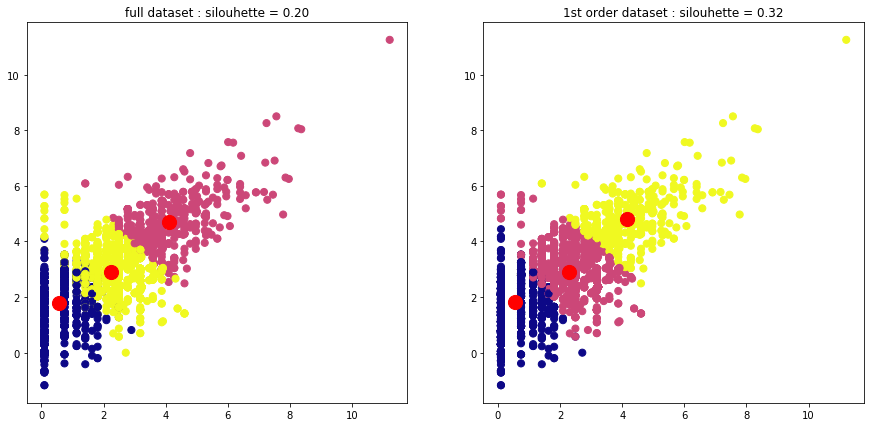

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
nclust = 3
# Full dataset with 1st order and main order data
data = customers_df_log.values
kmeans = cluster.KMeans(n_clusters=nclust, n_init=100)
kmeans.fit(data)
clusters_customers = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, nclust))
#create a scatter plot
ax1.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');
#select cluster centers
centers = kmeans.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
ax1.set_title("full dataset : silouhette = %.2f" % silhouette_avg)
# Number of customers in each cluster?
display(pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomersFull']).T)
    
data = customers_df_log.iloc[:, :3].values
kmeans = cluster.KMeans(n_clusters=nclust, n_init=100)
kmeans.fit(data)
clusters_customers = kmeans.predict(data)
silhouette_avg = metrics.silhouette_score(data, clusters_customers)
print('silhouette score : {:<.3f} for {} clusters'.format(silhouette_avg, nclust))
#create a scatter plot
ax2.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');
#select cluster centers
centers = kmeans.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
ax2.set_title("1st order dataset : silouhette = %.2f" % silhouette_avg)
# Number of customers in each cluster?
display(pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T)

We will forget about the main orders features for two reasons : it does not help in classify customers from their 1st order and it does not improve our customers clustering

Does our 1st order clustering works on our RFM data ?

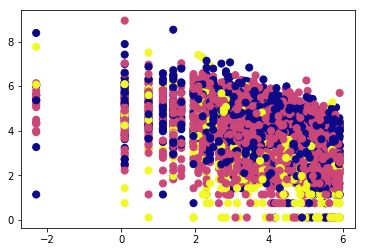

In [56]:
data = customers_rfm_log.values
#create a scatter plot
plt.scatter(data[:, 0], data[:, 1], c=clusters_customers, s=50, cmap='plasma');

Clearly not

# 7) Saving clustered dataframe for later classification

In [58]:
out_df = pd.concat((customers_bulk, pd.DataFrame(clusters_customers_bulk, index=customers_bulk.index, columns=['Segment'])), axis=1)

In [91]:
out_df.to_csv("data/segmented_customers.csv")

Load main dataset, add segmentation as a feature

In [60]:
try :
    online_retail_clean = pd.read_csv(path + "/data/online_retail_clean.csv")
    print("Loading customers dataset")
    display(online_retail_clean.head())
except FileNotFoundError:
    print("ERROR : check if the files are in the 'data' folder")

Loading customers dataset


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_enc,Amount,Bulk
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,3626,15.30,1.690141
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3626,20.34,1.366743
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,3626,22.00,2.133333
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3626,20.34,1.366743
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3626,20.34,1.366743


In [62]:
def get_segment(ID_enc) :
    """
    Small snippet to retrieve clustered segment for customer ID encoded
    """
    
    segment = out_df.loc[ID_enc, "Segment"]
    
    return segment
    
online_retail_clean['Segment'] = online_retail_clean.loc[:, 'CustomerID_enc'].apply(get_segment)

Just checking if we get our clustering back from this manipulation

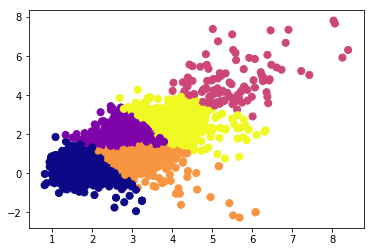

In [63]:
test_bulk_df = online_retail_clean.groupby('CustomerID_enc').agg({'Amount': lambda x: x.mean(),
                                                                  'Bulk': lambda x: x.mean(),
                                                                  'Segment': lambda x: x.mean()})
df_temp = test_bulk_df.loc[:, ["Amount", "Bulk"]].apply(lambda x : np.add(x, 0.1)) # Avoiding taking the log of zeros
test_bulk_df_log = df_temp.apply(np.log)

plt.scatter(test_bulk_df_log.loc[:, "Amount"], test_bulk_df_log.loc[:, "Bulk"], c=test_bulk_df.loc[:, "Segment"].values,
           s=50, cmap='plasma');

We do

In [64]:
online_retail_clean.to_csv("data/online_retail_clean_segmented.csv", index=False)